# **Microfinance organizations clients classification**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
data = pd.read_csv('data.csv', sep=';')
print(f'shape of data: {data.shape}')
data.head().iloc[:, [x for x in range(5)] + [x for x in range(-5, 0)]]

shape of data: (255820, 126)


,ID,feature_1,feature_2,feature_3,feature_4,feature_121,feature_122,feature_123,feature_124,target
0,1,1,0,0,1381,4000,7526.3157,12000,0.583333,0
1,2,0,0,0,1809,1000,8393.4426,30000,0.333333,0
2,3,0,0,0,1804,1000,3425.9259,15000,0.200000,0
3,4,0,0,0,1560,1000,1946.6666,3000,0.666667,0
4,5,0,0,0,258,2000,4444.4444,8000,0.250000,0


In [3]:
verify = pd.read_csv('verify.csv', sep=';')
print(f'shape of verify data: {verify.shape}')
verify.head().iloc[:, [x for x in range(5)] + [x for x in range(-5, 0)]]

shape of verify data: (56030, 125)


,ID,feature_1,feature_2,feature_3,feature_4,feature_120,feature_121,feature_122,feature_123,feature_124
0,255821,0,0,0,2268,6000,1000,4551.0204,12000,0.500000
1,255822,0,0,0,42,6000,3400,4700.0000,6000,1.000000
2,255823,0,0,0,265,3000,3000,4133.3333,6000,0.500000
3,255824,1,0,0,834,2000,1000,3875.0000,11000,0.181818
4,255825,0,0,0,772,8000,2000,7640.0000,12000,0.666667


## Обработка данных

Посмотрим на распределение классов.

In [4]:
data.target.value_counts()

target
0    205310
1     50510
Name: count, dtype: int64

Имеется дисбаланс классов!

Проверим данные на наличие дубликатов.

In [5]:
duplicates = data.duplicated()
print(f"Количество дубликатов в data: {duplicates.sum()}")
duplicates = verify.duplicated()
print(f"Количество дубликатов в verify: {duplicates.sum()}")

Количество дубликатов в data: 0
Количество дубликатов в verify: 0


In [6]:
# Вычисляем количество пропусков
missing_values = data.isna().sum()

# Вычисляем долю пропусков
total_rows = len(data)
missing_fraction = missing_values / total_rows

# Создаем DataFrame с именами признаков, количеством и долей пропусков
missing_columns_df = pd.DataFrame({
    'Column Name': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing Fraction': missing_fraction.values
})

# Фильтруем только те столбцы, где есть пропуски
missing_columns_df = missing_columns_df[missing_columns_df['Missing Count'] > 0]

# Сброс индексов для удобства
missing_columns_df.reset_index(drop=True, inplace=True)

# Выводим полученный DataFrame
missing_columns_df

,Column Name,Missing Count,Missing Fraction
0,feature_102,37795,0.147741
1,feature_103,37795,0.147741
2,feature_104,37795,0.147741
3,feature_105,37795,0.147741
4,feature_106,41893,0.163760


Доля пропусков не фатальная: если будем обучать линейные модели, то нужно применить способ заполнения пропусков либо удалить строки; если лесом пойдём, то пропуски нам не страшны.

In [7]:
# Вычисляем количество пропусков
verify_missing_values = verify.isna().sum()

# Вычисляем долю пропусков
verify_total_rows = len(verify)
verify_missing_fraction = verify_missing_values / verify_total_rows

# Создаем DataFrame с именами признаков, количеством и долей пропусков
verify_missing_columns_df = pd.DataFrame({
    'Column Name': verify_missing_values.index,
    'Missing Count': verify_missing_values.values,
    'Missing Fraction': verify_missing_fraction.values
})

# Фильтруем только те столбцы, где есть пропуски
verify_missing_columns_df = verify_missing_columns_df[verify_missing_columns_df['Missing Count'] > 0]

# Сброс индексов для удобства
verify_missing_columns_df.reset_index(drop=True, inplace=True)

# Выводим полученный DataFrame
verify_missing_columns_df

,Column Name,Missing Count,Missing Fraction
0,feature_102,11459,0.204515
1,feature_103,11459,0.204515
2,feature_104,11459,0.204515
3,feature_105,11459,0.204515
4,feature_106,12960,0.231305


А в тестовых данных доля пропусков побольше! Но они в тех же столбцах.


Мы можем предварительно посмотреть на то, как расположены пропуски в данных.

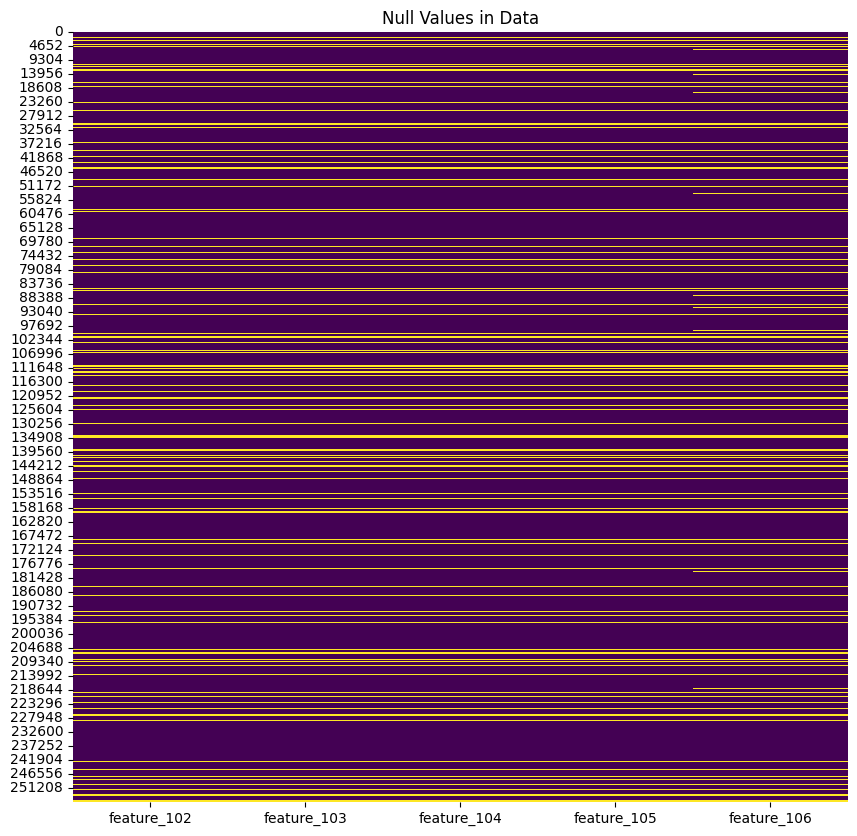

In [8]:
# Создадим тепловую карту для визуализации пропусков
plt.figure(figsize=(10, 10))
sns.heatmap(data[
    missing_columns_df['Column Name'].values.tolist()
    ].isna(), cbar=False, cmap='viridis')
plt.title('Null Values in Data')
plt.show()

Очень похоже на то, что пропуски по этим признакам расположены в одних и тех же строках, кроме некоторого отличия с feature_106.

Бороться с пропусками можно по-разному: заместить значениями показателей центральной тенденции, сгенерировать данные, удалить строки. По-хорошему, серьёзный анализ включает в себя проверку всех способов. Но а мы опробуем здесь генерацию данных с помощью регрессионного метода.

In [9]:
# Список колонок с пропусками
columns_with_nans = missing_columns_df['Column Name'].values.tolist()
data[columns_with_nans].describe()

,feature_102,feature_103,feature_104,feature_105,feature_106
count,218025.000000,218025.000000,218025.000000,218025.000000,213927.000000
mean,59.992574,17.457980,59.184222,241.548387,0.352597
std,194.964719,124.375112,147.625042,359.238223,0.518324
min,-490.000000,-948.000000,-153.000000,-81.000000,-76.600000
25%,4.000000,0.000000,11.000000,34.000000,0.031646
50%,11.000000,1.000000,23.000000,108.000000,0.146341
75%,32.000000,5.000000,51.000000,283.000000,0.752187
max,3278.000000,3278.000000,3278.000000,3278.000000,9.428571


In [10]:
%%time
data_copy = data.copy()
verify_copy = verify.copy()

# Функция для заполнения пропусков
def fill_missing_with_regression(original_df1, original_df2, columns_with_nans, target_column):
    # Создаем копию данных из первой таблицы
    df1 = original_df1.copy()

    # Разделяем данные на обучающую и тестовую выборки
    train_data = df1[df1[target_column].notnull()]
    test_data = pd.concat([df1[df1[target_column].isnull()], original_df2[original_df2[target_column].isnull()]], keys=['df1', 'df2'])

    # Определяем признаки и целевую переменную
    X_train = train_data.drop(columns=['ID'] + columns_with_nans)
    y_train = train_data[target_column]

    # Создаем и обучаем модель
    model = CatBoostRegressor(verbose=0)

    # Оценка качества модели с помощью кросс-валидации
    scores = cross_val_score(
        model, X_train, y_train,
        n_jobs=-1, cv=5,
        scoring='neg_root_mean_squared_error'
    )
    print(f'Кросс-валидация для {target_column}: RMSE = {-scores.mean()}')

    # Обучаем модель на всех доступных данных
    model.fit(X_train, y_train)

    # Заполняем пропуски
    if not test_data.empty:
        X_test = test_data.drop(columns=['ID'] + columns_with_nans)
        filled_values = model.predict(X_test)

        # Получаем индексы заполненных значений
        test_indices = test_data.index

        # Заполняем пропуски в оригинальных DataFrame
        for value, idx in zip(filled_values, test_indices):
            if idx[0] == 'df1':
                original_df1.loc[original_df1.index == idx[1], target_column] = value
            else:
                original_df2.loc[original_df2.index == idx[1], target_column] = value

# Заполнение пропусков для каждого признака
for column in columns_with_nans:
    fill_missing_with_regression(data_copy, verify_copy, columns_with_nans, column)

Кросс-валидация для feature_102: RMSE = 143.196549198904
Кросс-валидация для feature_103: RMSE = 69.32459390497452
Кросс-валидация для feature_104: RMSE = 75.99690259899991
Кросс-валидация для feature_105: RMSE = 169.82633112374583
Кросс-валидация для feature_106: RMSE = 0.40003599524780525
CPU times: total: 12min 39s
Wall time: 6min 34s


In [11]:
# Скопируем данные для базового решения
baseline_data = data.copy()
# Заполним пропуски средними 
baseline_data.fillna(baseline_data.mean(), inplace=True)

Разделим данные на X и y.

In [12]:
# Разделение данных на признаки и целевую переменную
X_lin = baseline_data.drop(['ID', 'target'], axis=1)
y_lin = baseline_data['target']

In [16]:
# from sklearn.neighbors import LocalOutlierFactor

In [17]:
# clf = LocalOutlierFactor(n_jobs=-1).fit_predict(X_lin)
# pd.Series(clf).value_counts()

 1    246600
-1      9220
Name: count, dtype: int64

In [24]:
# X_lin_lof = X_lin[clf == 1]
# y_lin_lof = y_lin[clf == 1]

In [14]:
# Разделение на обучающую и тестовую выборки
# X_lin_lof_train, X_lin_lof_valid, y_lin_lof_train, y_lin_lof_valid = train_test_split(
#     X_lin_lof, y_lin_lof, stratify=y_lin_lof, test_size=0.2, random_state=42
#     )

# lin_lof_scaler = StandardScaler()
# X_lin_lof_train_scaled = lin_lof_scaler.fit_transform(X_lin_lof_train)
# X_lin_lof_valid_scaled = lin_lof_scaler.transform(X_lin_lof_valid)

In [ ]:
# Разделение на обучающую и тестовую выборки
# X_lin_train, X_lin_valid, y_lin_train, y_lin_valid = train_test_split(
#     X_lin_lof, y_lin, stratify=y_lin, test_size=0.2, random_state=42
#     )

# lin_scaler = StandardScaler()
# X_lin_train_scaled = lin_scaler.fit_transform(X_lin_train)
# X_lin_valid_scaled = lin_scaler.transform(X_lin_valid)

In [15]:
# Разделение на обучающую и тестовую выборки
X_lin_train, X_lin_valid, y_lin_train, y_lin_valid = train_test_split(
    X_lin, y_lin, stratify=y_lin, test_size=0.2, random_state=42
    )

lin_scaler = StandardScaler()
X_lin_train_scaled = lin_scaler.fit_transform(X_lin_train)
X_lin_valid_scaled = lin_scaler.transform(X_lin_valid)

print('X_lin_train.shape:', X_lin_train.shape)
print('y_lin_train.shape:', y_lin_train.shape)
print('X_lin_valid.shape:', X_lin_valid.shape)
print('y_lin_valid.shape:', y_lin_valid.shape)

X_lin_train.shape: (204656, 124)
y_lin_train.shape: (204656,)
X_lin_valid.shape: (51164, 124)
y_lin_valid.shape: (51164,)


In [18]:
# generative filling
X_gf = data_copy.drop(['ID', 'target'], axis=1)
y_gf = data_copy['target']

In [19]:
# Разделение на обучающую и тестовую выборки
X_gf_train, X_gf_valid, y_gf_train, y_gf_valid = train_test_split(
    X_gf, y_gf, stratify=y_gf, test_size=0.2, random_state=42
    )

gf_scaler = StandardScaler()
X_gf_train_scaled = gf_scaler.fit_transform(X_gf_train)
X_gf_valid_scaled = gf_scaler.transform(X_gf_valid)

У нас был дисбаланс в классах, поэтому можно попробовать использовать синтетическое увеличение данных (ADASYN/SMOTE).

SMOTE (Synthetic Minority Over-sampling Technique) создает новые синтетические примеры, интерполируя между существующими примерами. Это позволяет увеличить количество объектов, сохраняя при этом разнообразие данных.

ADASYN (Adaptive Synthetic) генерирует разное количество выборок в зависимости от оценки локального распределения класса, подлежащего избыточной выборке.

In [20]:
# Применение ADASYN
lin_adasyn = ADASYN(random_state=42)
X_lin_adasyn_train, y_lin_adasyn_train = lin_adasyn.fit_resample(X_lin_train, y_lin_train)
X_lin_adasyn_valid, y_lin_adasyn_valid = X_lin_valid, y_lin_valid
print("Распределение классов до ADASYN:   ", Counter(y_lin_train))
print("Распределение классов после ADASYN:", Counter(y_lin_adasyn_train))

Распределение классов до ADASYN:    Counter({0: 164248, 1: 40408})
Распределение классов после ADASYN: Counter({0: 164248, 1: 156503})


In [21]:
lin_adasyn_scaler = StandardScaler()
X_lin_adasyn_train_scaled = lin_adasyn_scaler.fit_transform(X_lin_adasyn_train)
X_lin_adasyn_valid_scaled = lin_adasyn_scaler.transform(X_lin_adasyn_valid)

In [22]:
gf_adasyn = ADASYN(random_state=42)
X_gf_adasyn_train, y_gf_adasyn_train = gf_adasyn.fit_resample(X_gf_train, y_gf_train)
X_gf_adasyn_valid, y_gf_adasyn_valid = X_gf_valid, y_gf_valid
print("Распределение классов до ADASYN:   ", Counter(y_gf_train))
print("Распределение классов после ADASYN:", Counter(y_gf_adasyn_train))

Распределение классов до ADASYN:    Counter({0: 164248, 1: 40408})
Распределение классов после ADASYN: Counter({0: 164248, 1: 156605})


In [23]:
gf_adasyn_scaler = StandardScaler()
X_gf_adasyn_train_scaled = gf_adasyn_scaler.fit_transform(X_gf_adasyn_train)
X_gf_adasyn_valid_scaled = gf_adasyn_scaler.transform(X_gf_adasyn_valid)

In [24]:
# Применение SMOTE
lin_smote = SMOTE(random_state=42)
X_lin_smote_train, y_lin_smote_train = lin_smote.fit_resample(X_lin_train, y_lin_train)
X_lin_smote_valid, y_lin_smote_valid = X_lin_valid, y_lin_valid
print("Распределение классов до SMOTE:   ", Counter(y_lin_train))
print("Распределение классов после SMOTE:", Counter(y_lin_smote_train))

lin_smote_scaler = StandardScaler()
X_lin_smote_train_scaled = lin_smote_scaler.fit_transform(X_lin_smote_train)
X_lin_smote_valid_scaled = lin_smote_scaler.transform(X_lin_smote_valid)

Распределение классов до SMOTE:    Counter({0: 164248, 1: 40408})
Распределение классов после SMOTE: Counter({0: 164248, 1: 164248})


In [25]:
gf_smote = SMOTE(random_state=42)
X_gf_smote_train, y_gf_smote_train = gf_smote.fit_resample(X_gf_train, y_gf_train)
X_gf_smote_valid, y_gf_smote_valid = X_gf_valid, y_gf_valid
print("Распределение классов до SMOTE:   ", Counter(y_gf_train))
print("Распределение классов после SMOTE:", Counter(y_gf_smote_train))

gf_smote_scaler = StandardScaler()
X_gf_smote_train_scaled = gf_smote_scaler.fit_transform(X_gf_smote_train)
X_gf_smote_valid_scaled = gf_smote_scaler.transform(X_gf_smote_valid)

Распределение классов до SMOTE:    Counter({0: 164248, 1: 40408})
Распределение классов после SMOTE: Counter({0: 164248, 1: 164248})


In [26]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_lin), y=y_lin)
class_weights_dict = {i: cw for i, cw in enumerate(class_weights)}

## Моделирование

In [27]:
def get_metrics(model, X_train, X_valid, y_train, y_valid, train_metrics=True):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    
    # Расчет roc_auc
    train_roc_auc = roc_auc_score(y_train, train_pred_proba)

    # ROC-кривая и коэффициент Джини
    fpr_train, tpr_train, train_thresholds = roc_curve(
        y_train, train_pred_proba
        )
    train_roc_auc_value = auc(fpr_train, tpr_train)
    train_gini_coefficient = 2 * train_roc_auc_value - 1
    
    # Расчет roc_auc
    valid_roc_auc = roc_auc_score(y_valid, valid_pred_proba)

    # ROC-кривая и коэффициент Джини
    fpr_valid, tpr_valid, valid_thresholds = roc_curve(
        y_valid, valid_pred_proba
        )
    valid_roc_auc_value = auc(fpr_valid, tpr_valid)
    valid_gini_coefficient = 2 * valid_roc_auc_value - 1
    
    # Оценка модели
    train_report = classification_report(
        y_train, train_preds, digits=4
        )
    
    valid_report = classification_report(
        y_valid, valid_preds, digits=4
        )
    
    # Вывод результатов
    if train_metrics:
        print(f'Train ROC AUC:   {train_roc_auc:.4f}')
        print(f'Train Gini Coef: {train_gini_coefficient:.4f}')
        print(train_report, '\n')
    
    print(f'Val ROC AUC:   {valid_roc_auc:.4f}')
    print(f'Val Gini Coef: {valid_gini_coefficient:.4f}')
    print(valid_report)
    
    return fpr_valid, tpr_valid, valid_thresholds

#### Baseline LogisticRegression

In [29]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_lin_train_scaled, y_lin_train)

lr_roc_curve = get_metrics(
    lr_model, X_lin_train_scaled, X_lin_valid_scaled,
    y_lin_train, y_lin_valid, train_metrics=False
    )

Val ROC AUC:   0.7719
Val Gini Coef: 0.5438
              precision    recall  f1-score   support

           0     0.8278    0.9686    0.8927     41062
           1     0.5861    0.1809    0.2764     10102

    accuracy                         0.8131     51164
   macro avg     0.7070    0.5747    0.5845     51164
weighted avg     0.7801    0.8131    0.7710     51164

CPU times: total: 14 s
Wall time: 14 s


#### class weighted

In [30]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(
    solver='liblinear',
    class_weight=class_weights_dict
    )
lr_model.fit(X_lin_train_scaled, y_lin_train)

lr_roc_curve = get_metrics(
    lr_model, X_lin_train_scaled, X_lin_valid_scaled,
    y_lin_train, y_lin_valid, train_metrics=False
    )

Val ROC AUC:   0.7733
Val Gini Coef: 0.5466
              precision    recall  f1-score   support

           0     0.9062    0.7085    0.7953     41062
           1     0.3721    0.7020    0.4864     10102

    accuracy                         0.7073     51164
   macro avg     0.6392    0.7053    0.6408     51164
weighted avg     0.8008    0.7073    0.7343     51164

CPU times: total: 11.1 s
Wall time: 10.9 s


---

#### generative filling

In [31]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_gf_train_scaled, y_gf_train)

lr_roc_curve = get_metrics(
    lr_model, X_gf_train_scaled, X_gf_valid_scaled,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Val ROC AUC:   0.7689
Val Gini Coef: 0.5379
              precision    recall  f1-score   support

           0     0.8276    0.9681    0.8923     41062
           1     0.5814    0.1803    0.2752     10102

    accuracy                         0.8125     51164
   macro avg     0.7045    0.5742    0.5838     51164
weighted avg     0.7790    0.8125    0.7705     51164

CPU times: total: 13.7 s
Wall time: 13.7 s


#### generative filling + class weighted

In [32]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(
    solver='liblinear',
    class_weight=class_weights_dict
    )
lr_model.fit(X_gf_train_scaled, y_gf_train)

lr_roc_curve = get_metrics(
    lr_model, X_gf_train_scaled, X_gf_valid_scaled,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Val ROC AUC:   0.7703
Val Gini Coef: 0.5407
              precision    recall  f1-score   support

           0     0.9060    0.7037    0.7922     41062
           1     0.3686    0.7031    0.4837     10102

    accuracy                         0.7036     51164
   macro avg     0.6373    0.7034    0.6379     51164
weighted avg     0.7999    0.7036    0.7313     51164

CPU times: total: 9.98 s
Wall time: 9.71 s


#### ADASYN

In [34]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_gf_adasyn_train_scaled, y_gf_adasyn_train)

lr_roc_curve = get_metrics(
    lr_model,
    X_gf_adasyn_train_scaled, X_gf_adasyn_valid_scaled,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.7613
Val Gini Coef: 0.5227
              precision    recall  f1-score   support

           0     0.8298    0.9579    0.8893     41062
           1     0.5408    0.2015    0.2936     10102

    accuracy                         0.8086     51164
   macro avg     0.6853    0.5797    0.5915     51164
weighted avg     0.7728    0.8086    0.7717     51164

CPU times: total: 31.3 s
Wall time: 31.2 s


#### MLPClassifier

In [35]:
%%time
# Инициализация и обучение модели
mlpc = MLPClassifier(
    batch_size=128,
    max_iter=2000,
    n_iter_no_change=30,
    early_stopping=True
)
mlpc.fit(X_gf_adasyn_train_scaled, y_gf_adasyn_train)

mlpc_roc_curve = get_metrics(
    mlpc, 
    X_gf_adasyn_train_scaled, X_gf_adasyn_valid_scaled,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.7827
Val Gini Coef: 0.5654
              precision    recall  f1-score   support

           0     0.8452    0.9397    0.8899     41062
           1     0.5507    0.3002    0.3886     10102

    accuracy                         0.8135     51164
   macro avg     0.6979    0.6200    0.6393     51164
weighted avg     0.7870    0.8135    0.7910     51164

CPU times: total: 1min 53s
Wall time: 1min 6s


#### KNeighborsClassifier

In [36]:
%%time
# Инициализация объекта
knc = KNeighborsClassifier(n_jobs=-1)

knc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

knc_roc_curve = get_metrics(
    knc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.6311
Val Gini Coef: 0.2621
              precision    recall  f1-score   support

           0     0.8517    0.6811    0.7569     41062
           1     0.2854    0.5178    0.3680     10102

    accuracy                         0.6489     51164
   macro avg     0.5686    0.5995    0.5625     51164
weighted avg     0.7399    0.6489    0.6801     51164

CPU times: total: 1h 10min 28s
Wall time: 6min 34s


#### DecisionTreeClassifier

In [37]:
%%time
# Инициализация и обучение модели
dtc = DecisionTreeClassifier()

dtc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

dtc_roc_curve = get_metrics(
    dtc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.6096
Val Gini Coef: 0.2192
              precision    recall  f1-score   support

           0     0.8476    0.8149    0.8309     41062
           1     0.3496    0.4043    0.3749     10102

    accuracy                         0.7339     51164
   macro avg     0.5986    0.6096    0.6029     51164
weighted avg     0.7492    0.7339    0.7409     51164

CPU times: total: 14.4 s
Wall time: 14.4 s


#### BaggingClassifier

In [38]:
%%time
bc = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)
bc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

bc_roc_curve = get_metrics(
    bc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.7501
Val Gini Coef: 0.5003
              precision    recall  f1-score   support

           0     0.8435    0.9288    0.8841     41062
           1     0.5085    0.2994    0.3769     10102

    accuracy                         0.8045     51164
   macro avg     0.6760    0.6141    0.6305     51164
weighted avg     0.7773    0.8045    0.7839     51164

CPU times: total: 1.86 s
Wall time: 24.6 s


#### RandomForestClassifier

In [39]:
%%time
# Инициализация и обучение модели
rfc = RandomForestClassifier(n_jobs=-1)

rfc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

rfc_roc_curve = get_metrics(
    rfc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.7930
Val Gini Coef: 0.5860
              precision    recall  f1-score   support

           0     0.8487    0.9374    0.8909     41062
           1     0.5578    0.3208    0.4074     10102

    accuracy                         0.8157     51164
   macro avg     0.7033    0.6291    0.6491     51164
weighted avg     0.7913    0.8157    0.7954     51164

CPU times: total: 3min 37s
Wall time: 21.1 s


#### ExtraTreesClassifier

In [40]:
%%time
# Инициализация и обучение модели
etc = ExtraTreesClassifier(n_jobs=-1)

etc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

etc_roc_curve = get_metrics(
    etc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.7760
Val Gini Coef: 0.5519
              precision    recall  f1-score   support

           0     0.8382    0.9340    0.8835     41062
           1     0.4991    0.2673    0.3481     10102

    accuracy                         0.8024     51164
   macro avg     0.6686    0.6006    0.6158     51164
weighted avg     0.7713    0.8024    0.7778     51164

CPU times: total: 3min 59s
Wall time: 23.3 s


#### LGBMClassifier

In [41]:
%%time
# Инициализация и обучение модели
lgbmc = LGBMClassifier()

lgbmc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

lgbmc_roc_curve = get_metrics(
    lgbmc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.7993
Val Gini Coef: 0.5986
              precision    recall  f1-score   support

           0     0.8458    0.9517    0.8956     41062
           1     0.6002    0.2950    0.3956     10102

    accuracy                         0.8220     51164
   macro avg     0.7230    0.6233    0.6456     51164
weighted avg     0.7973    0.8220    0.7969     51164

CPU times: total: 31.1 s
Wall time: 4.31 s


#### HistGradientBoostingClassifier

In [42]:
%%time
# Инициализация и обучение модели
hgbc = HistGradientBoostingClassifier()
# Обучение
hgbc.fit(X_gf_adasyn_train, y_gf_adasyn_train)
# Предсказание и получение метрик
hgbc_roc_curve = get_metrics(
    hgbc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.7982
Val Gini Coef: 0.5964
              precision    recall  f1-score   support

           0     0.8453    0.9525    0.8957     41062
           1     0.6014    0.2914    0.3926     10102

    accuracy                         0.8220     51164
   macro avg     0.7234    0.6220    0.6442     51164
weighted avg     0.7971    0.8220    0.7964     51164

CPU times: total: 50 s
Wall time: 10.2 s


#### XGBClassifier

In [43]:
%%time
# Инициализация и обучение модели
xgbc = XGBClassifier()
# Обучение
xgbc.fit(X_gf_adasyn_train, y_gf_adasyn_train)
# Предсказание и получение метрик
xgbc_roc_curve = get_metrics(
    xgbc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.7953
Val Gini Coef: 0.5906
              precision    recall  f1-score   support

           0     0.8486    0.9446    0.8940     41062
           1     0.5828    0.3148    0.4088     10102

    accuracy                         0.8202     51164
   macro avg     0.7157    0.6297    0.6514     51164
weighted avg     0.7961    0.8202    0.7982     51164

CPU times: total: 29.4 s
Wall time: 3.19 s


#### CatBoostClassifier

In [44]:
%%time
# Инициализация и обучение модели
cbc = CatBoostClassifier(verbose=0)
# Обучение
cbc.fit(X_gf_adasyn_train, y_gf_adasyn_train)
# Предсказание и получение метрик
cbc_roc_curve = get_metrics(
    cbc, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

Val ROC AUC:   0.8053
Val Gini Coef: 0.6106
              precision    recall  f1-score   support

           0     0.8481    0.9513    0.8967     41062
           1     0.6081    0.3074    0.4083     10102

    accuracy                         0.8241     51164
   macro avg     0.7281    0.6293    0.6525     51164
weighted avg     0.8007    0.8241    0.8003     51164

CPU times: total: 3min 56s
Wall time: 24.8 s


Что-то бустинговые алгоритмы разочаровали.

### Optimization

Здесь с optuna подбираются гиперпараметры алгоритмов.

#### Optimized LogisticRegression

In [46]:
# %%time
# # Определение функции для оптимизации
# def optuna_lr(trial):
#     """Функция, обучающая модель LogisticRegression по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
#     if penalty == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
#     else:
#         l1_ratio = None

#     solver = trial.suggest_categorical('solver', ['newton-cg', 'newton-cholesky', 'lbfgs', 'liblinear', 'saga'])

#     if penalty == 'l1' and solver in ['newton-cg', 'newton-cholesky', 'lbfgs', 'sag']:
#         return 0.0 # 'l1' penalty is not supported by these solvers
#     elif penalty == 'elasticnet' and solver not in ['saga']:
#         return 0.0 # 'elasticnet' penalty is supported only by 'saga' solver
    
#     # Инициализация LogisticRegression с оптимизируемыми гиперпараметрами
#     clf = LogisticRegression(
#         C=C, penalty=penalty, solver=solver,
#         l1_ratio=l1_ratio, max_iter=10000,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = cross_val_score(
#         clf, X_lin_train_scaled, y_lin_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_lr = optuna.create_study(study_name="lr_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# n_trials = 50
# with tqdm(total=n_trials, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lr.optimize(optuna_lr, n_trials=n_trials, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lr.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# lr_opt = LogisticRegression(
#     **study_lr.best_params,
#     max_iter=10000,
#     random_state=42
# )

# # Обучение алгоритма на оптимальных параметрах
# lr_opt.fit(X_lin_train_scaled, y_lin_train)
# # Получить отчет по модели
# lr_opt_roc_curve = get_metrics(
#     lr_opt, X_lin_train_scaled, X_lin_valid_scaled,
#     y_lin_train, y_lin_valid, train_metrics=False
#     )

#### Optimized DecisionTreeClassifier

In [45]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_dtc(trial):
    """Функция, обучающая модель DecisionTreeClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 37)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50, 2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Создаем модель
    model=DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42        
    )   
    # Рассчитаем метрику на кросс-валидации
    score = cross_val_score(
        model, X_gf_adasyn_train, y_gf_adasyn_train, cv=5, scoring="f1", n_jobs=-1
    ).mean()
    return score


# Создание и запуск оптимизации с отображением прогресса с помощью tqdm
study_dtc = optuna.create_study(study_name="dtc_opt", direction='maximize')
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Мониторим прогресс оптимизации
n_trials=50
with tqdm(total=n_trials, desc="Optimizing") as pbar:
    def update(study, trial):
        pbar.update(1)
    # Ищем лучшую комбинацию гиперпараметров n_trials раз
    study_dtc.optimize(optuna_dtc, n_trials=n_trials, callbacks=[update])

# Получение оптимальных гиперпараметров
print("Лучшие гиперпараметры:", study_dtc.best_params)

# Передаем модели коллекцию оптимальных гиперпараметров
dtc_opt = DecisionTreeClassifier(
    **study_dtc.best_params,
    random_state=42
)

# Обучение алгоритма на оптимальных параметрах
dtc_opt.fit(X_gf_adasyn_train, y_gf_adasyn_train)
# Получить отчет по модели
dtc_opt_roc_curve = get_metrics(
    dtc_opt, X_gf_adasyn_train, X_gf_adasyn_valid,
    y_gf_adasyn_train, y_gf_adasyn_valid, train_metrics=False
    )

[I 2024-12-24 23:40:09,534] A new study created in memory with name: dtc_opt
Optimizing: 100%|██████████| 50/50 [08:00<00:00,  9.61s/it]


Лучшие гиперпараметры: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 27, 'min_samples_split': 16, 'min_samples_leaf': 7}
Val ROC AUC:   0.6746
Val Gini Coef: 0.3491
              precision    recall  f1-score   support

           0     0.8499    0.8422    0.8460     41062
           1     0.3813    0.3953    0.3882     10102

    accuracy                         0.7540     51164
   macro avg     0.6156    0.6188    0.6171     51164
weighted avg     0.7574    0.7540    0.7556     51164

CPU times: total: 29.3 s
Wall time: 8min 13s


#### Optimized RandomForestClassifier

In [51]:
# Напишем функцию для оптимизации
def optuna_rfc(trial):
    """Функция, обучающая модель RandomForest по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1-weighted
    """
    # Задаем пространство поиска гиперпараметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 45),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    # Инициализация RandomForest с оптимизируемыми гиперпараметрами
    clf = RandomForestClassifier(
        **params,
        n_jobs=-1,
        random_state=42
    )
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(
        clf, X_gf_adasyn_train, y_gf_adasyn_train,
        cv=3, scoring="f1_weighted", n_jobs=-1
    ).mean()
    
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_rfc = optuna.create_study(study_name="rfc_opt", direction='maximize')
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Мониторим прогресс оптимизации
n_trials=20
with tqdm(total=n_trials, desc="Optimizing") as pbar:
    def update(study, trial):
        pbar.update()
    # Ищем лучшую комбинацию гиперпараметров n_trials раз
    study_rfc.optimize(optuna_rfc, n_trials=n_trials, callbacks=[update])

# Получение оптимальных гиперпараметров
print("Лучшие гиперпараметры:", study_rfc.best_params)

# Передаем модели коллекцию оптимальных гиперпараметров
rfc_opt = RandomForestClassifier(
    **study_rfc.best_params,
    n_jobs=-1, random_state=42
    )

# Обучение алгоритма на оптимальных параметрах
rfc_opt.fit(X_gf_adasyn_train, y_gf_adasyn_train)
# Получить отчет по модели
rfc_opt_roc_curve = get_metrics(
    rfc_opt, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Optimizing: 100%|██████████| 20/20 [33:00<00:00, 99.03s/it] 


Лучшие гиперпараметры: {'n_estimators': 458, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}
Test ROC AUC:   0.9849
Test Gini Coef: 0.9697
              precision    recall  f1-score   support

           0     0.9701    0.9868    0.9784     41062
           1     0.9421    0.8764    0.9080     10102

    accuracy                         0.9650     51164
   macro avg     0.9561    0.9316    0.9432     51164
weighted avg     0.9646    0.9650    0.9645     51164



### Thresholding

In [47]:
def get_optim_threshold(roc_curve_data):
    fpr, tpr, thresholds = roc_curve_data

    # Оптимальный порог можно найти, например, по максимизации F1-меры
    f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [48]:
def get_optim_thresh_rep(model, X_valid, y_valid, roc_curve_data):
    optimal_threshold = get_optim_threshold(roc_curve_data)
    valid_preds = model.predict_proba(X_valid)
    optimal_test_predictions = (valid_preds.tolist() >= optimal_threshold).astype(int)
    print(classification_report(y_valid, optimal_test_predictions[:, 1], digits=4))

In [49]:
get_optim_thresh_rep(dtc, X_gf_valid, y_gf_valid, rfc_roc_curve)

              precision    recall  f1-score   support

           0     0.8476    0.8149    0.8309     41062
           1     0.3496    0.4043    0.3749     10102

    accuracy                         0.7339     51164
   macro avg     0.5986    0.6096    0.6029     51164
weighted avg     0.7492    0.7339    0.7409     51164



In [50]:
get_optim_thresh_rep(rfc, X_gf_valid, y_gf_valid, rfc_roc_curve)

              precision    recall  f1-score   support

           0     0.9154    0.7023    0.7948     41062
           1     0.3783    0.7363    0.4998     10102

    accuracy                         0.7090     51164
   macro avg     0.6469    0.7193    0.6473     51164
weighted avg     0.8094    0.7090    0.7366     51164



In [51]:
get_optim_thresh_rep(etc, X_gf_valid, y_gf_valid, rfc_roc_curve)

              precision    recall  f1-score   support

           0     0.8996    0.7475    0.8166     41062
           1     0.3918    0.6610    0.4919     10102

    accuracy                         0.7304     51164
   macro avg     0.6457    0.7042    0.6542     51164
weighted avg     0.7993    0.7304    0.7525     51164



---

## Final

### Final LogReg

In [52]:
%%time

lr_final = LogisticRegression(
    solver='liblinear',
    class_weight=class_weights_dict
    )
lr_final.fit(X_lin_train_scaled, y_lin_train)
lr_final_train_preds = lr_final.predict(X_lin_train_scaled)
print(classification_report(y_lin_train, lr_final_train_preds, digits=4))
lr_final_valid_preds = lr_final.predict(X_lin_valid_scaled)
print(classification_report(y_lin_valid, lr_final_valid_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9069    0.7103    0.7967    164248
           1     0.3741    0.7036    0.4884     40408

    accuracy                         0.7090    204656
   macro avg     0.6405    0.7070    0.6426    204656
weighted avg     0.8017    0.7090    0.7358    204656

              precision    recall  f1-score   support

           0     0.9062    0.7085    0.7953     41062
           1     0.3721    0.7020    0.4864     10102

    accuracy                         0.7073     51164
   macro avg     0.6392    0.7053    0.6408     51164
weighted avg     0.8008    0.7073    0.7343     51164

CPU times: total: 11 s
Wall time: 10.9 s


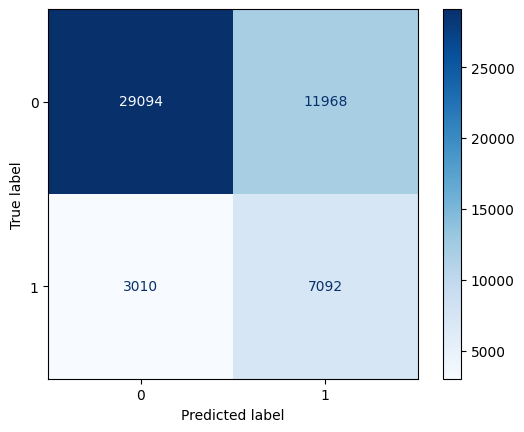

In [53]:
# Вычисляем матрицу путаницы
cm = confusion_matrix(y_lin_valid, lr_final_valid_preds)
# Визуализация матрицы путаницы
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues);

In [54]:
train_preds_proba = lr_final.predict_proba(X_lin_train_scaled)
valid_preds_proba = lr_final.predict_proba(X_lin_valid_scaled)

In [55]:
def get_table(train_probs, valid_probs, y_train, y_valid):
    # Создание DataFrame из вероятностей
    train_df = pd.DataFrame({'Вероятность': train_probs[:, 1], 'target': y_train.values})
    valid_df = pd.DataFrame({'Вероятность': valid_probs[:, 1], 'target': y_valid.values})

    # Определение интервалов
    bins = np.around(np.arange(0.0, 1.1, 0.1), 1).tolist()  # Создание границ интервалов
    labels = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]  # Создание меток для интервалов

    # Разбиение на интервалы
    train_df['Интервал'] = pd.cut(
        train_df['Вероятность'], bins=bins,
        labels=labels, right=True, include_lowest=True
        )
    valid_df['Интервал'] = pd.cut(
        valid_df['Вероятность'], bins=bins,
        labels=labels, right=True, include_lowest=True
        )

    # Группировка по интервалам и подсчет для тренировочной выборки
    train_result = train_df.groupby('Интервал', observed=False).agg(
        Всего_в_группе=('Вероятность', 'size'),
        Кол_во_target_1=('target', lambda x: (x == 1).sum()),
    ).reset_index()

    # Группировка по интервалам и подсчет для валидационной выборки
    valid_result = valid_df.groupby('Интервал', observed=False).agg(
        Всего_в_группе=('Вероятность', 'size'),
        Кол_во_target_1=('target', lambda x: (x == 1).sum()),
    ).reset_index()

    # Переименование столбцов
    train_result.columns = ['Интервал', 'Всего в группе (train)', 'Кол-во target 1 (train)']
    valid_result.columns = ['Интервал', 'Всего в группе (valid)', 'Кол-во target 1 (valid)']

    # Объединение результатов
    final_result = pd.merge(train_result, valid_result, on='Интервал', how='outer')

    # Переименование столбца для вероятности
    final_result['Вероятность'] = final_result['Интервал'].apply(lambda x: f"{x[0]} - {x[1]}")

    # Упорядочивание столбцов
    final_result = final_result[['Вероятность', 'Всего в группе (train)', 'Кол-во target 1 (train)', 
                                'Всего в группе (valid)', 'Кол-во target 1 (valid)']]

    display(final_result)
    
    
get_table(train_preds_proba, valid_preds_proba, y_lin_train, y_lin_valid)

,Вероятность,Всего в группе (train),Кол-во target 1 (train),Всего в группе (valid),Кол-во target 1 (valid)
0,0.0 - 0.1,5500,93,1414,29
1,0.1 - 0.2,29618,1000,7444,259
2,0.2 - 0.3,34930,2342,8563,585
3,0.3 - 0.4,30502,3569,7648,864
4,0.4 - 0.5,28098,4973,7035,1273
5,0.5 - 0.6,25494,6507,6269,1611
6,0.6 - 0.7,20668,7043,5236,1751
7,0.7 - 0.8,15327,6666,3917,1681
8,0.8 - 0.9,9553,5012,2418,1271
9,0.9 - 1.0,4966,3203,1220,778


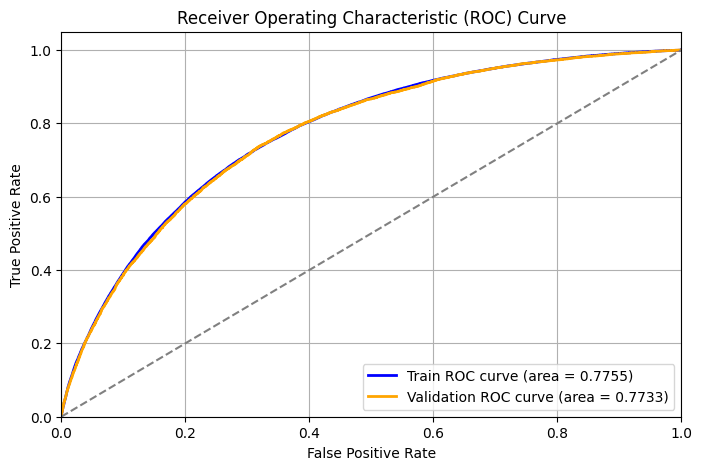

In [56]:
def get_roc_curves(train_probs, valid_probs, y_train, y_valid):
    # Вычисление ROC-кривой и AUC для тренировочной выборки
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs[:, 1])
    roc_auc_train = auc(fpr_train, tpr_train)

    # Вычисление ROC-кривой и AUC для валидационной выборки
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_probs[:, 1])
    roc_auc_valid = auc(fpr_valid, tpr_valid)

    # Визуализация ROC-кривой
    plt.figure(figsize=(8, 5))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = {:.4f})'.format(roc_auc_train))
    plt.plot(fpr_valid, tpr_valid, color='orange', lw=2, label='Validation ROC curve (area = {:.4f})'.format(roc_auc_valid))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайного выбора
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    

get_roc_curves(train_preds_proba, valid_preds_proba, y_lin_train, y_lin_valid)

### Final ETC

In [57]:
%%time

etc_final = ExtraTreesClassifier(n_jobs=-1)
etc_final.fit(X_gf_adasyn_train, y_gf_adasyn_train)
etc_final_train_preds = etc_final.predict(X_gf_adasyn_train)
print(classification_report(y_gf_adasyn_train, etc_final_train_preds, digits=4))
etc_final_valid_preds = etc_final.predict(X_gf_adasyn_valid)
print(classification_report(y_gf_adasyn_valid, etc_final_valid_preds, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    164248
           1     1.0000    1.0000    1.0000    156605

    accuracy                         1.0000    320853
   macro avg     1.0000    1.0000    1.0000    320853
weighted avg     1.0000    1.0000    1.0000    320853

              precision    recall  f1-score   support

           0     0.8378    0.9337    0.8831     41062
           1     0.4956    0.2650    0.3454     10102

    accuracy                         0.8016     51164
   macro avg     0.6667    0.5993    0.6142     51164
weighted avg     0.7702    0.8016    0.7769     51164

CPU times: total: 3min 40s
Wall time: 21.2 s


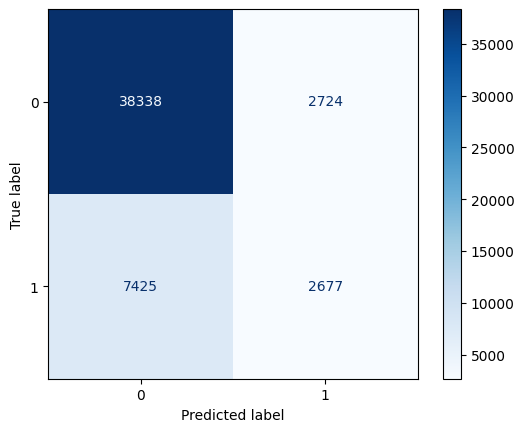

In [58]:
# Вычисляем матрицу путаницы
cm = confusion_matrix(y_gf_adasyn_valid, etc_final_valid_preds)
# Визуализация матрицы путаницы
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues);

In [59]:
train_preds_proba = etc_final.predict_proba(X_gf_adasyn_train)
valid_preds_proba = etc_final.predict_proba(X_gf_adasyn_valid)

In [60]:
get_table(train_preds_proba, valid_preds_proba, y_gf_adasyn_train, y_gf_adasyn_valid)

,Вероятность,Всего в группе (train),Кол-во target 1 (train),Всего в группе (valid),Кол-во target 1 (valid)
0,0.0 - 0.1,164248,0,19880,1006
1,0.1 - 0.2,0,0,8571,1214
2,0.2 - 0.3,0,0,7009,1582
3,0.3 - 0.4,0,0,5905,1841
4,0.4 - 0.5,0,0,4398,1782
5,0.5 - 0.6,0,0,2851,1354
6,0.6 - 0.7,0,0,1543,790
7,0.7 - 0.8,0,0,736,382
8,0.8 - 0.9,0,0,241,141
9,0.9 - 1.0,156605,156605,30,10


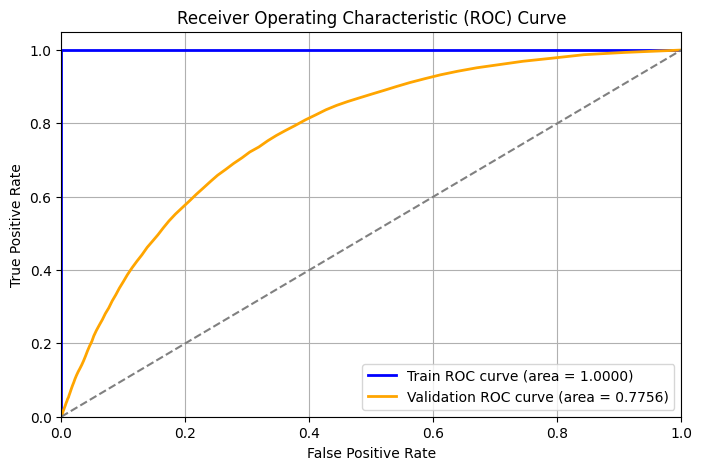

In [61]:
get_roc_curves(train_preds_proba, valid_preds_proba, y_gf_adasyn_train, y_gf_adasyn_valid)

## verify

### by LR

In [62]:
lr_full = LogisticRegression(
    solver='lbfgs',
    max_iter=1000, n_jobs=-1,
    class_weight=class_weights_dict
    )
lr_full.fit(X_lin, y_lin)

lr_full_pred_proba = lr_full.predict_proba(X_lin)[:, 1]
# Расчет roc_auc
lr_full_roc_auc = roc_auc_score(y_lin, lr_full_pred_proba)
# ROC-кривая и коэффициент Джини
fpr, tpr, thresholds = roc_curve(
    y_lin, lr_full_pred_proba
    )
lr_full_roc_auc_value = auc(fpr, tpr)
lr_full_gini_coefficient = 2 * lr_full_roc_auc_value - 1
print(f'LR ROC AUC:   {lr_full_roc_auc_value:.4f}')
print(f'LR Gini Coef: {lr_full_gini_coefficient:.4f}')
lr_full_data_preds = lr_full.predict(X_lin)
print(classification_report(y_lin, lr_full_data_preds, digits=4))

LR ROC AUC:   0.7302
LR Gini Coef: 0.4605
              precision    recall  f1-score   support

           0     0.8900    0.7031    0.7856    205310
           1     0.3490    0.6469    0.4534     50510

    accuracy                         0.6920    255820
   macro avg     0.6195    0.6750    0.6195    255820
weighted avg     0.7832    0.6920    0.7200    255820



In [63]:
verify_X = verify_copy.drop('ID', axis=1)
lr_full_verify_preds = lr_full.predict(verify_X)
lr_full_verify_probs = lr_full.predict_proba(verify_X)

pd.Series(lr_full_verify_preds).value_counts()

0    31209
1    24821
Name: count, dtype: int64

In [64]:
lr_verify_result = pd.DataFrame(verify['ID'])
lr_verify_result['score'] = lr_full_verify_probs[:, 1]

lr_verify_result.to_csv('lr_verify_result.csv', sep=';', index=False)

### by ETC

In [66]:
adasyn = ADASYN(random_state=42)
X_gf_adasyn, y_gf_adasyn = adasyn.fit_resample(X_gf, y_gf)
print("Распределение классов до ADASYN:   ", Counter(y_gf))
print("Распределение классов после ADASYN:", Counter(y_gf_adasyn))

Распределение классов до ADASYN:    Counter({0: 205310, 1: 50510})
Распределение классов после ADASYN: Counter({0: 205310, 1: 195677})


In [67]:
%%time

etc_full = ExtraTreesClassifier(n_jobs=-1)
etc_full.fit(X_gf_adasyn, y_gf_adasyn)
etc_full_data_preds = etc_full.predict(X_gf)
etc_full_pred_proba = etc_full.predict_proba(X_gf)[:, 1]
# Расчет roc_auc
etc_full_roc_auc = roc_auc_score(y_gf, etc_full_pred_proba)
# ROC-кривая и коэффициент Джини
fpr, tpr, thresholds = roc_curve(
    y_gf, etc_full_pred_proba
    )
etc_full_roc_auc_value = auc(fpr, tpr)
etc_full_gini_coefficient = 2 * etc_full_roc_auc_value - 1
print(f'ETC ROC AUC:   {etc_full_roc_auc_value:.4f}')
print(f'ETC Gini Coef: {etc_full_gini_coefficient:.4f}')
etc_full_data_preds = etc_full.predict(X_gf)
print(classification_report(y_gf, etc_full_data_preds, digits=4))

ETC ROC AUC:   1.0000
ETC Gini Coef: 1.0000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    205310
           1     1.0000    1.0000    1.0000     50510

    accuracy                         1.0000    255820
   macro avg     1.0000    1.0000    1.0000    255820
weighted avg     1.0000    1.0000    1.0000    255820

CPU times: total: 5min 23s
Wall time: 31.2 s


In [68]:
verify_X = verify_copy.drop('ID', axis=1)
etc_full_verify_preds = etc_full.predict(verify_X)
etc_full_verify_probs = etc_full.predict_proba(verify_X)

In [69]:
pd.Series(etc_full_verify_preds).value_counts()

0    49041
1     6989
Name: count, dtype: int64

In [70]:
etc_verify_result = pd.DataFrame(verify['ID'])
etc_verify_result['score'] = etc_full_verify_probs[:, 1]

In [71]:
etc_verify_result.to_csv('etc_verify_result.csv', sep=';', index=False)